## This notebook is to train Catboost model to classify ion images as on-sample provided with a subset of user-labelled images
## The images are downloaded from a joint core_metabolome3 + spotting database if their fdr is below 50%

In [1]:
%matplotlib notebook

from pathlib import Path
from definitions import ROOT_DIR
import numpy as np
import pandas as pd
import os
from datetime import datetime
import tifffile as tif
from scipy.stats import ks_2samp

from catboost import CatBoostClassifier, Pool
from scipy.ndimage import binary_dilation
from sklearn import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from metaspace import SMInstance
sm = SMInstance()

from metaspace.image_processing import clip_hotspots
import getpass

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
def get_mispredictions(model, X, y):
    """
    Find which values would be mispredicted, returning two lists:
        * indexes of items that would be falsely predicted as positives
        * indexes of items that would be falsely predicted as negatives
        
    cross_val_predict uses a shuffled 5-fold test-train split so that each chunk of 
    20% of the input data gets its own model that was trained on the other 80%, 
    ensuring that the items being predicted aren't included in the training data.
    """
    preds = cross_val_predict(model, X, y)
    mispreds = preds != y
    fpos_idxs = np.flatnonzero(mispreds & ~y)
    fneg_idxs = np.flatnonzero(mispreds & y)
        
    return fpos_idxs, fneg_idxs

In [3]:
def get_images(ds_name, id_map, compounds):
    
    ds = sm.dataset(name = ds_name)
    ds_tic_image = ds.tic_image()

    images = []

    for img in ds.all_annotation_images(
        fdr=0.5, 
        database=399, #core metabolome and spotting db
        only_first_isotope=True, 
        scale_intensity=True, 
        hotspot_clipping=False):
        
        # Only consider spotted metabolites
        if img.formula in compounds.formula.unique():
        
            # Exclude annotations with no first-isotopic-image
            if img[0] is not None:

                ion_img = img[0]
                tic_norm_img = np.nan_to_num(ion_img / ds_tic_image)

                images.append({
                    'dataset_name': ds_name,
                    'formula': img.formula,
                    'adduct': img.adduct,
                    'neutral_loss': img.neutral_loss or '',
                    'image': ion_img,
                    'tic_norm_image': tic_norm_img
                    })
            
    images_df = pd.DataFrame(images) 
    del(images)

    # add metadata
    results = ds.results(database = 399, include_neutral_losses=True)  
    metadata = results[['ion', 'offSample', 'mz', 'moleculeNames', 'msm', 'fdr']].reset_index()
    metadata.rename(columns={'neutralLoss' : 'neutral_loss'}, inplace=True)
    images_df = images_df.merge(metadata, how='left', on=['formula', 'adduct', 'neutral_loss'])
    images_df = images_df.merge(id_map, on='dataset_name', how='left')
    images_df['filename'] = [f"{x.old_id}_{x.formula}_{x.adduct}{x.neutral_loss}.png" for x in images_df.itertuples()]
    images_df['row_id'] = [f"{x.old_id}_{x.formula}_{x.adduct}{x.neutral_loss}" for x in images_df.itertuples()]

    return images_df

def prepare_tissue_mask(p_mask):
    mask = tif.imread(p_mask)
    mask = mask / 255 # scale to only 0 and 1 
    mask = binary_dilation(mask, iterations=3)
    return mask

def calc_far_bg(mask):
    """Gets mask for background pixels that are away from the tissue by n=7 dilation cycles"""
    far_bg = ~binary_dilation(mask, iterations=7)
    return far_bg

def occ(px):
    """Calculates non-zero % of the given array"""
    return np.count_nonzero(px) / px.size

def calculate_metrics(images_df, binary):

    metrics = []
    for row in images_df.itertuples():

        mask = binary == 1
        bg = binary == 0
        far_bg = calc_far_bg(mask)

        in_mask = row.image[mask]        
        in_bg = row.image[bg]
        in_far_bg = row.image[far_bg]
        
        in_mask_tic = row.tic_norm_image[mask]
        in_bg_tic = row.tic_norm_image[bg]
        in_far_bg_tic = row.tic_norm_image[far_bg]
        
        # Calculate KS statistic 
        d_stat, p_val = ks_2samp(in_mask, in_bg)
        d_stat_tic, p_val_tic = ks_2samp(in_mask_tic, in_bg_tic)

#       If there is more signal in off-sample area compared to the well area, make statistic negative
        if np.mean(in_bg) > np.mean(in_mask):
            d_stat = d_stat*-1
        if np.mean(in_bg_tic) > np.mean(in_mask_tic):
            d_stat_tic = d_stat_tic*-1

        metrics.append({
            'dataset_name' : row.dataset_name,
            'formula' : row.formula,
            'adduct' : row.adduct,
            'neutral_loss' : row.neutral_loss,
            'ion' : row.ion,
            'old_id' : row.old_id,
            'new_id' : row.new_id,
            'row_id': row.row_id,
            'filename': row.filename,
            'msm': row.msm,
            'fdr': row.fdr,
            
            'sample_intensity' : np.mean(in_mask),
            'tic_sample_intensity' : np.mean(in_mask_tic),
            'far_bgr_corrected_intensity' : np.mean(in_mask) - np.mean(in_far_bg),
            
            'intensity_ratio': np.mean(in_mask) / (np.mean(in_bg)+0.001),
            'intensity_vs_far_bg_ratio': np.mean(in_mask) / (np.mean(in_far_bg) + 0.001),
            'tic_intensity_ratio': np.mean(in_mask_tic) / (np.mean(in_bg_tic)+0.001),
            'tic_intensity_vs_far_bg_ratio': np.mean(in_mask_tic) / (np.mean(in_far_bg) + 0.001),
            
            'image_occupancy' : occ(row.image),
            'sample_occupancy' : occ(in_mask),
            'bg_occupancy': occ(in_bg),
            'far_bgr_occupancy':occ(in_far_bg),
            'occupancy_ratio': occ(in_mask) / (occ(in_bg)+0.001),
            'occupancy_vs_far_bg_ratio' : occ(in_mask) / (occ(in_far_bg) + 0.001),
    
            'ks_score' : d_stat, 
            'ks_score_tic' : p_val, # note that there was a typo in this block
            'ks_pval' : p_val_tic, # also here
            'ks_pval_tic' : p_val_tic, # also here
        })

    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [4]:
p_home = Path(ROOT_DIR) / "spotting_vs_metaspace"
p_analysis = p_home / "catboost"
p_masks = p_analysis / 'tissue_masks'
p_labels = p_analysis / r"labels_for_model_training"
p_id_map = p_analysis / "id_map.csv"
p_compounds = Path(ROOT_DIR).parents[0] / r"5_data_analysis/wellmap.csv"

timestamp = datetime.now().strftime("%d-%b-%Y") 

# Paths for evaluation
p_eval = p_analysis/ "model_results_with_fdr"
p_metrics = p_eval / "metrics.csv"
p_eval_preds = p_eval / 'predictions.csv'
p_predictions = p_eval / f"tissue_predictions_{timestamp}.csv"
p_predictions_curated = p_eval / f"all_predictions_curated_{timestamp}.csv"
p_model = p_analysis/ "model_results" / "model.json"
# False positives/negatives - preview output from model prediction for molecules with known labels
# Note that all files in these directories are cleared before a prediction run
p_eval_fpos = p_eval / 'false_positives'
p_eval_fneg = p_eval / 'false_negatives'
p_eval_tpos = p_eval / 'true_positives'
p_eval_tneg = p_eval / 'true_negatives'
# Unknown positives/negatives - preview output from model prediction for molecules with no label
# Note that all files in these directories are cleared before a prediction run
p_eval_upos = p_eval / 'unknown_positives'
p_eval_uneg = p_eval / 'unknown_negatives'
# Manually labeled positives/negatives - Move preview files from any of the above directories into 
# these directories to add to the labelled data. Make sure to re-run the appropriate steps 
# in "Input data" to detect the changes
p_eval_lpos = p_eval / 'manual_label_positives'
p_eval_lneg = p_eval / 'manual_label_negatives'

# Directories for three-state positive/unsure/negative classification
p_tri_pos = p_eval / 'three-state' / 'positive'
p_tri_unk = p_eval / 'three-state' / 'unsure'
p_tri_neg = p_eval / 'three-state' / 'negative'

- Get dataset names (from tissue mask folder)

In [5]:
mask_names = list(p_masks.rglob("*.tif"))
dataset_names = [x.stem + " - extended" for x in mask_names]

- Get images for each dataset
- Download images from metaspace or load them in if they were pre-saved

In [6]:
# Log into metaspace
sm = SMInstance(host='https://metaspace2020.eu')

if not sm.logged_in():
    # Using getpass here prevents the API key from being accidentally saved with this notebook.
    api_key = getpass.getpass(prompt='API key: ', stream=None)
    sm.login(api_key=api_key)

- Calculate metrics for individual datasets

In [7]:
compounds = pd.read_csv(p_compounds)
id_map = pd.read_csv(p_id_map)

metric_list = []
k=0
for ds_name, p_mask in list(zip(dataset_names, mask_names)):
    print(ds_name, k)
    k+=1    
    
    images_df = get_images(ds_name, id_map, compounds)
    images_df.to_pickle(p_eval / f"{ds_name}_images.pickle")
#     images_df = pd.read_pickle(p_eval / f"{ds_name}_images.pickle")
    mask = prepare_tissue_mask(p_mask)
    if images_df.image[0].shape != mask.shape:
        print(ds_name, p_mask, "problem\n")
        break
    metrics = calculate_metrics(images_df, mask)
    metric_list.append(metrics)
    del(images_df)

metrics_df = pd.concat(metric_list)
metrics_df.set_index("row_id", inplace=True)
metrics_df.to_csv(p_metrics)

02112020_VS_NH1_11-2A_treatment_att29_px45_109x168_DAN_neg Cloned - extended 0


100%|████████████████████████████████████████| 4191/4191 [00:18<00:00, 228.27it/s]                                     


02112020_VS_NH1_18-1_control_att29_px45_96x91_DAN_neg Cloned - extended 1


100%|████████████████████████████████████████| 3160/3160 [00:15<00:00, 199.95it/s]                                     


071119_Opt_CBO_Brain_maldi5_168x164p50_DAN_neg Cloned - extended 2


100%|████████████████████████████████████████| 1297/1297 [00:06<00:00, 210.18it/s]                                     


20191021_Opt_Sanger_Brain_150sx75p_DANx_neg Cloned - extended 3


100%|████████████████████████████████████████| 1775/1775 [00:08<00:00, 197.33it/s]                                     


20191022_Opt_Sanger_Brain_150sx75p_DHB_pos Cloned - extended 4


100%|████████████████████████████████████████| 4188/4188 [00:21<00:00, 192.04it/s]                                     


2020-07-18_ME_Liver_Naive_DHB_Pos_120-1200_300x300_25umss Cloned - extended 5


100%|████████████████████████████████████████| 2050/2050 [00:11<00:00, 178.21it/s]                                     


2020-07-19_ME_Liver_UV_DHB_Pos_120-1200_300x275_25umss_32at Cloned - extended 6


100%|████████████████████████████████████████| 1786/1786 [00:10<00:00, 167.83it/s]                                     


2020-08-27_ME_X130L2_29at_25umss_420x240 Cloned - extended 7


100%|████████████████████████████████████████| 5683/5683 [00:35<00:00, 162.32it/s]                                     


2020-08-28_ME_X190L4_29at_25umss_240x200 Cloned - extended 8


100%|████████████████████████████████████████| 5479/5479 [00:30<00:00, 178.15it/s]                                     


2020-08-28_ME_X190L6_10um_29at_25umss_350x300 Cloned - extended 9


100%|████████████████████████████████████████| 6819/6819 [00:40<00:00, 169.86it/s]                                     


2020-09-06_ME_X190_L6_5um_25umss_CHCA_Pos_340x320_31at Cloned - extended 10


100%|████████████████████████████████████████| 5276/5276 [00:33<00:00, 157.93it/s]                                     


2020-09-17_ME_X190_L1_15um_20umss_DHB_Pos_475x220_31at Cloned - extended 11


100%|████████████████████████████████████████| 5268/5268 [00:34<00:00, 154.52it/s]                                     


2020-10-26_ME_L11_Slide9_210x360_20um_ss_31at Cloned - extended 12


100%|████████████████████████████████████████| 4599/4599 [00:28<00:00, 163.94it/s]                                     


2020-10-26_ME_L5_Slide9_330x170_20um_ss_31at Cloned - extended 13


100%|████████████████████████████████████████| 3956/3956 [00:23<00:00, 167.97it/s]                                     


2020-10-28_ME_L2_Slide9_230x300_20um_ss_31at Cloned - extended 14


100%|████████████████████████████████████████| 4380/4380 [00:26<00:00, 167.84it/s]                                     


2020-10-28_ME_VS_NHI-11-2B_DHB_Pos_40um_ss_116x182_31AT_pos Cloned - extended 15


100%|████████████████████████████████████████| 4934/4934 [00:26<00:00, 183.97it/s]                                     


2020-10-28_ME_VS_NHI-18-2_DHB_Pos_40um_ss_87x107_pos Cloned - extended 16


100%|████████████████████████████████████████| 3649/3649 [00:19<00:00, 187.78it/s]                                     


2021-04-26_ME_X190L1-9_29at_25umss_310x190 Cloned - extended 17


100%|████████████████████████████████████████| 3240/3240 [00:18<00:00, 176.88it/s]                                     


2021-04-27_ME_X190L3-9_29at_25umss_152x142 Cloned - extended 18


100%|████████████████████████████████████████| 3212/3212 [00:17<00:00, 182.96it/s]                                     


2021-04-28_ME_X190L6-9_29at_25umss_240x217 Cloned - extended 19


100%|████████████████████████████████████████| 3217/3217 [00:17<00:00, 179.33it/s]                                     


2021-04-29_ME_X190L8-8_29at_25umss_134x320_concat Cloned - extended 20


100%|████████████████████████████████████████| 4940/4940 [00:28<00:00, 171.97it/s]                                     


2021-06-30_ME_X190L5-7_29at_20umss_250x200 Cloned - extended 21


100%|████████████████████████████████████████| 8728/8728 [00:49<00:00, 174.78it/s]                                     


2021-07-03_ME_X190L6-8_29at_20umss_280x230 Cloned - extended 22


100%|████████████████████████████████████████| 6241/6241 [00:38<00:00, 164.09it/s]                                     


26102018_CBO_SHA_brainDAN_p100_s80 Cloned - extended 23


100%|████████████████████████████████████████| 2047/2047 [00:10<00:00, 196.79it/s]                                     


ZM6_long_B6female_epsilon_LI_DAN27repeat_s150 Cloned - extended 24


100%|████████████████████████████████████████| 6472/6472 [00:36<00:00, 178.36it/s]                                     
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


ZM6_long_B6female_epsilon_LI_DHB26repeat_s160 Cloned - extended 25


100%|████████████████████████████████████████| 14198/14198 [01:32<00:00, 152.78it/s]                                   


ZM6_long_B6female_epsilon_SI4_DHB26repeat_s150 Cloned - extended 26


100%|████████████████████████████████████████| 12660/12660 [01:20<00:00, 157.59it/s]                                   


ZM6_long_B6female_epsilon_SI5_DAN27_s150 Cloned - extended 27


100%|████████████████████████████████████████| 4711/4711 [00:23<00:00, 198.04it/s]                                     
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


ZM6_long_B6female_omega_LI-repeat_DHB26repeat_s150 Cloned - extended 28


100%|████████████████████████████████████████| 13848/13848 [01:30<00:00, 152.47it/s]                                   


ZM6_long_B6female_omega_LI_DAN27repeat_s150 Cloned - extended 29


100%|████████████████████████████████████████| 6013/6013 [00:34<00:00, 171.98it/s]                                     


ZM6_long_B6female_omega_SI4_DAN27_s150 Cloned - extended 30


100%|████████████████████████████████████████| 3569/3569 [00:19<00:00, 183.26it/s]                                     


ZM6_long_B6female_omega_SI5_DHB26_s150 Cloned - extended 31


100%|████████████████████████████████████████| 12903/12903 [01:17<00:00, 167.22it/s]                                   


ZM6_long_B6male_beta_LI3_DHB26_s150 Cloned - extended 32


100%|████████████████████████████████████████| 17355/17355 [01:56<00:00, 148.52it/s]                                   
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


ZM6_long_B6male_beta_LI5_DAN27_s150 Cloned - extended 33


100%|████████████████████████████████████████| 6869/6869 [00:39<00:00, 171.79it/s]                                     


ZM6_long_B6male_beta_SI6_DAN27_s150 Cloned - extended 34


100%|████████████████████████████████████████| 5485/5485 [00:33<00:00, 161.95it/s]                                     


ZM6_long_B6male_beta_SI7_DHB26_s85 Cloned - extended 35


100%|████████████████████████████████████████| 17395/17395 [01:51<00:00, 156.59it/s]                                   


ZM6_long_B6male_delta_LI_DAN27 Cloned - extended 36


100%|████████████████████████████████████████| 5833/5833 [00:44<00:00, 131.20it/s]                                     


ZM6_long_B6male_delta_LI_DHB26 Cloned - extended 37


100%|████████████████████████████████████████| 18737/18737 [02:20<00:00, 133.81it/s]                                   


ZM6_long_B6male_delta_SI4_DHB26_s85 Cloned - extended 38


100%|████████████████████████████████████████| 15952/15952 [01:55<00:00, 137.92it/s]                                   


ZM6_long_B6male_delta_SI6_DAN27_s85 Cloned - extended 39


100%|████████████████████████████████████████| 4063/4063 [00:38<00:00, 106.14it/s]                                     


In [9]:
# or load pre-saved
metrics_df = pd.read_csv(p_metrics, index_col=0)
metrics_df.neutral_loss = metrics_df.neutral_loss.fillna("")

## Apply model

In [10]:
model = CatBoostClassifier(verbose=False)
model.load_model(p_model, format='json')
features = [
            'intensity_vs_far_bg_ratio', 
            'occupancy_ratio', 
            'ks_score', 
            'ks_pval',
            'image_occupancy',
            'tic_intensity_vs_far_bg_ratio']

In [11]:
# Make predictions for all data
predictions_df = pd.DataFrame({
    'pred_val': model.predict_proba(metrics_df[features].values)[:, 1]
}, index=metrics_df.index)

In [12]:
output_df = metrics_df.join(predictions_df)

# Add two-state and three-state classes
output_df['prediction'] = np.where(output_df.pred_val < 0.75, 0, 1)

# write predicitons csv file
output_df.to_csv(p_predictions)

<IPython.core.display.Javascript object>


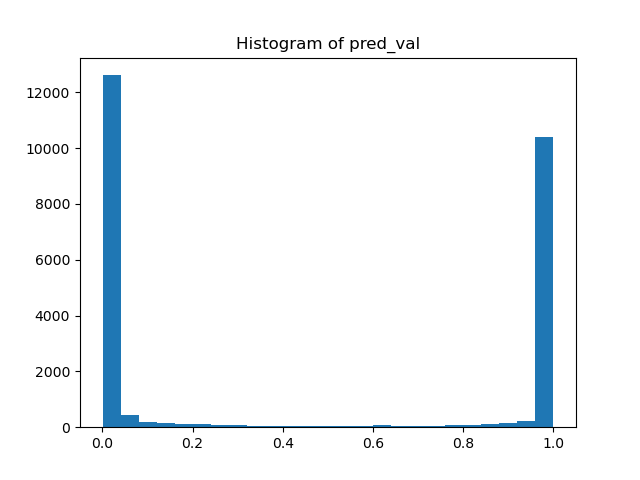

In [13]:
plt.figure()
plt.title("Histogram of pred_val")
plt.hist(output_df.pred_val.ravel(), 25)
plt.show()

### Write image files into false positives, false negatives, etc.

In [14]:
def colorize_image_with_mask(image, mask):
    """Plotting function for combining a colorized ion image with a spot mask"""
    image = clip_hotspots(image)
    on_spot_colorized = plt.cm.cividis(image)
    off_spot_colorized = plt.cm.magma(image)
    return np.where(mask[:,:,np.newaxis], on_spot_colorized, off_spot_colorized)
    
def save_image_with_mask(image, mask, fname):
    plt.imsave(fname, colorize_image_with_mask(image, mask))
    
    
def save_image(image, fname):
    plt.imsave(fname, clip_hotspots(image))

In [15]:
# Clean output directories
for output_path in [
    p_eval_upos, p_eval_uneg, 
]:
    output_path.mkdir(parents=True, exist_ok=True)
    for f in output_path.glob('*.png'):
        f.unlink()  # Delete existing files

for dataset_name in output_df.dataset_name.unique():
    
    #load inages
    images_df = pd.read_pickle(p_eval / f"{dataset_name}_images.pickle")
    images_df.set_index('row_id', inplace=True)
    
    subset = output_df[output_df.dataset_name == dataset_name]
    
    # Write images with two-state classification
    for row in subset.itertuples():
        
        image_to_write = images_df.loc[row[0], 'image']

        # Figure out which directory to use
        twostate_path = [p_eval_uneg, p_eval_upos][row.prediction]

        save_image(image_to_write, twostate_path / row.filename)